In [ ]:
import logging
logging.basicConfig(level=logging.DEBUG)

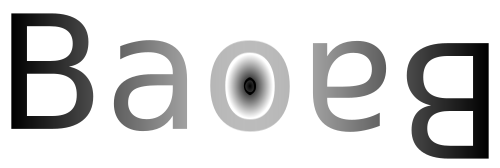

Baobao is a small library that attempts writing and maintaining data pipelines easier. It was written with Pandas in mind, but is not limited to it or even depends on it. It's AIP closely models Pandas pipe functionality.

Design principles are:
- Simple in the core
- Minimal dependencies
- Additional functionality is optional

Pipelines can be build like this:

In [ ]:
import pandas as pd
from baobao import Pipeline  # To define pipelines
from baobao import Step  # Pipelines are build from Steps which may contain Pipelines

# some functions that return pd.Dataframes to play with
from baobao.utils.examples import load_1, load_2, load_3

Pipeline(
    root_node=load_1,  # We have to start somewhere, could be any object or callable
    pipeline=(  # Pipelines are build from Steps
        Step(
            # Each Step is build from a function that takes 
            # the output of the previous Step as input in 
            # the first argument
            func=pd.merge,
            # Any argoments to [func] can be given
            left_index=True, right_index=True,
            right=Pipeline(load_2),  # including additional Pipelines
        ),
        Step(func=pd.merge, right=Pipeline(load_3), left_index=True, right_index=True),
    )
).run()  # Call the run method to actually run the pipeline, enjoy some logging out of the box

A neat way of speeding this up is caching results to disk:

In [ ]:
# Baobao doesn't depend on any caching but respects Joblibs
# API in case you want to chose some other caching strategy
from joblib import Memory

# Baobao options are separated into a dedicated object in
# order to make it simple to push options down to Pipelines
# included in Steps of the root Pipeline
from baobao import PipelineOpts

# Define the pipeline:
pipeline = Pipeline(
    root_node=load_1,
    opts=PipelineOpts(
        memory=Memory("./cache", verbose=0),
        push_options=True  # Pushing options down to included Pipelines
    ),
    pipeline=(
        Step(func=pd.merge, right=Pipeline(load_2), left_index=True, right_index=True),
        Step(func=pd.merge, right=Pipeline(load_3), left_index=True, right_index=True),
    )
)
# Run the pipeline:
pipeline.run()

Reasoning over pipelines might be simpler with this printing utility:

In [ ]:
from baobao.utils import print_pipeline
print_pipeline(pipeline)

Printing can be adjusted using the multiple dispatch pattern:

In [ ]:
from baobao.pipeline import str_
@str_.register
def _(inp: pd.DataFrame):
    return f"DataFrame(shape:{inp.shape})"
@str_.register
def _(inp: bool):
    return f"Bool:{inp}"

print_pipeline(pipeline)

A little more depth added:

In [ ]:
from baobao.utils.examples import *  # Import more load_X functions

def mk_pipeline():  # get fresh pipeline each time we call this function
    return Pipeline(
        root_node=load_1,
        opts=PipelineOpts(
            memory=None,#Memory("./cache", verbose=0),
            push_options=True
        ),
        pipeline=(
            Step(func=pd.merge, left_index=True, right_index=True, right=Pipeline(load_2)),
            Step(func=pd.merge, left_index=True, right_index=True, right=Pipeline(
                root_node=load_3,
                pipeline=(
                    Step(func=pd.merge, left_index=True, right_index=True, right=Pipeline(load_4)),
                    Step(func=pd.merge, left_index=True, right_index=True, right=Pipeline(
                        root_node=load_2,
                        pipeline=(
                            Step(func=pd.merge, left_index=True, right_index=True, right=Pipeline(load_5)),
                            Step(func=pd.merge, left_index=True, right_index=True, right=Pipeline(load_6)),
                        )
                    )),
                ))
                ),
            Step(func=pd.merge, left_index=True, right_index=True, right=Pipeline(load_5)),
        )
    )

Lets print this one again:

In [ ]:
print_pipeline(mk_pipeline())

and run it in a sequential manner:

In [ ]:
mk_pipeline().run()

We can speed things up by submitting those pipelines that do not contain further pipelines to a multiprocess Pool and enjoy some nice speedups:

In [ ]:
from baobao.utils import run_parallel

run_parallel(mk_pipeline(), n_jobs=4)